# Analytical Engineering

In [1]:
#Algorithmic/python stuff
from _collections_abc import Iterable
from typing import List, Tuple, Iterable
from collections import Counter

# File reading and loading
import json
import os

# Data analysis
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.manifold import TSNE

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

#Topological Feature Analysis
import gudhi

import math
import random
from sklearn.neighbors import KDTree
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

### JSON Data Extraction

In [2]:
#Convert JSON directories into point clouds:
def jsonToData(path):
  '''
  1. Traverses given directory
  2. finds json files
  3. parses them for their embeddings, names, spans, and paths
  4. returns a dictionary with all embeddings, nams, spans, and paths
  '''
  set = {'embeds':list(), 'names':list(), 'spans':list(), 'paths':list()}
  for root,dirs,files in os.walk(path):
    for file in files:
      if file.endswith('.json'):
        with open(root + '/' + file) as json_file:
          data = json.load(json_file)
          set['embeds'].append(data[0][0]) # Embedding
          set['names'].append(data[1]) # Identifier or token name
          set['spans'].append(data[2]) # Start and end indices in source code
          set['paths'].append(path) # Path to file
   # Turn lists into numpy arrays
  for key in set.keys():
    set[key] = np.array(set[key])
  return set

Class, Method, and Token dataset counts

In [4]:
#path where Ivy embeddings are located
path = 'data'

In [34]:
class_set = jsonToData(path + '/classes')
len(class_set['embeds'])

579

In [5]:
method_set = jsonToData(path + '/methods')
len(method_set['embeds'])

5351

In [ ]:
token_set = jsonToData(path + '/tokens')
len(token_set['embeds'])

378782

## Exploratory Data Analysis on Embedding Point Clouds

### 1. Assess location by comparing the points to the origin—compute a histogram of the ℓ2 norms

In [39]:

def computeL2Norms(embedding_cloud):
  '''
  Input: point cloud
  output: matplotlib histogram
  
  1. for each embedding in the cloud
  2. compute the l2 norm with numpy
  3. return a list of all the l2 norms
  4. compute the average
  5. plot a histogram of the l2 norms
  '''
  l2_norms = []
  for embedding in embedding_cloud:
    l2_norm = np.linalg.norm(embedding)
    l2_norms.append(l2_norm)

  avg = np.mean(l2_norms)
  std = np.std(l2_norms)
    


  fig = plt.hist(l2_norms, bins = len(l2_norms), histtype='step', color=['blue'], fill=True, alpha=0.05)
  plt.axvline(avg, color='k', linestyle='dashed',linewidth=1)
  plt.axvline(avg+std, color='red', linestyle='dashed',linewidth=1)
  plt.axvline(avg-std, color='red', linestyle='dashed',linewidth=1)

  return fig

<function matplotlib.pyplot.show(*args, **kw)>

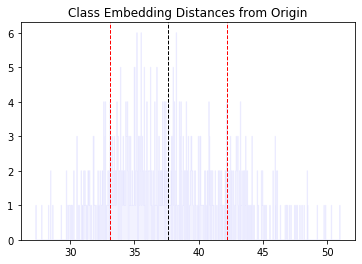

In [32]:
#Classes

computeL2Norms(class_set['embeds'])
plt.title("Class Embedding Distances from Origin")
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

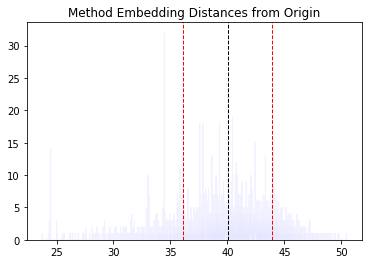

In [47]:
#Method

computeL2Norms(method_set['embeds'])
plt.title("Method Embedding Distances from Origin")
plt.show

378782


<function matplotlib.pyplot.show(*args, **kw)>

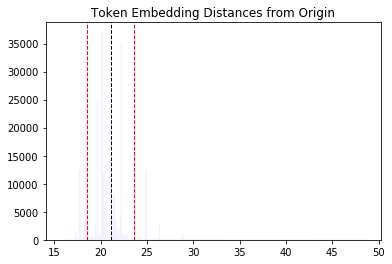

In [12]:
#Token

computeL2Norms(token_set['embeds'])
plt.title("Token Embedding Distances from Origin")
plt.show

### 2. Assess dimensionality

Correlation Matrices: finding features that are the most and least correlated

In [13]:
def correlationMatrix(embedding_cloud,title):
    '''
    input: point cloud and granularity string(for print statement)
    output: 5 most and least correlated features printed to system

    1. calculate correlation matrix with numby
    2. find 5 maximum values in the matrix and store their indices as a tupple
    3. do the same for the minimum values
    4. print these indices along with their values as a list
    '''

  
    if len(embedding_cloud) <= 1:
        print('Data not big enough!')
    else:
        print('Correation Matrix Analysis for ' + title + ' embeddings' )
        print()
        correlation_matrix = np.corrcoef(embedding_cloud,rowvar=False)
        corroef_to_list = []
        for i in range(len(correlation_matrix)):
            for j in range(len(correlation_matrix[i])):
                #store tuple (value, row, column)
                #do not add it if i and j are the same column
                if i != j:
                    corroef_to_list.append((correlation_matrix[i][j],i,j))
        #sort list by value
        sorted_list = sorted(corroef_to_list, key=lambda x: abs(x[0]))


        print('Top 5 most correlated features:')
        for i in range(5):
            item = sorted_list[len(sorted_list)-1-i]
            print(f"{item[1]} , {item[2]}:  {item[0]}")
        print()
        print('Top 5 least correlated features:')
        for i in range(5):
            item = sorted_list[i]
            print(f"{item[1]} , {item[2]}:  {item[0]}")



In [34]:
correlationMatrix(class_set['embeds'], 'Class')

Correation Matrix Analysis for Class embeddings

Top 5 most correlated features:
386 , 276:  0.813929642634631
276 , 386:  0.8139296426346309
613 , 248:  -0.7188328662379472
248 , 613:  -0.7188328662379471
523 , 169:  0.575419409029024

Top 5 least correlated features:
187 , 156:  -1.8994558358418775e-06
156 , 187:  -1.8994558358418777e-06
247 , 577:  -1.931013335446045e-06
577 , 247:  -1.931013335446045e-06
242 , 701:  -2.519828485723787e-06


In [48]:
correlationMatrix(method_set['embeds'], 'Method')

Correation Matrix Analysis for Method embeddings

Top 5 most correlated features:
276 , 386:  0.8798178840317118
386 , 276:  0.8798178840317117
276 , 613:  -0.6710237078384961
613 , 276:  -0.671023707838496
613 , 386:  -0.6369972142520478

Top 5 least correlated features:
235 , 466:  3.3485148684909854e-08
466 , 235:  3.348514868490986e-08
420 , 370:  -1.3145995014948712e-07
370 , 420:  -1.3145995014948715e-07
358 , 242:  -2.323425409144516e-07


In [14]:
correlationMatrix(token_set['embeds'], 'Token')

Correation Matrix Analysis for Token embeddings

Top 5 most correlated features:
248 , 276:  -0.8812676406855913
276 , 248:  -0.8812676406855912
692 , 316:  -0.7385736974084601
316 , 692:  -0.7385736974084601
717 , 248:  -0.7253570007589468

Top 5 least correlated features:
2 , 149:  -2.440324909201666e-07
149 , 2:  -2.440324909201666e-07
82 , 606:  2.9196561252874873e-07
606 , 82:  2.9196561252874873e-07
402 , 265:  -7.956705716435664e-07


Scree Plot Analysis: Sorting the Eigenvalues of the correlation matrix and looking for a signifcant drop in value should give us some indication of feature importance/how many features of the 768 are important

In [15]:
def eigenvaluePCA(embedding_cloud):
    '''
    input: point cloud
    output: matplotlib line graph

    Scree Plot Analysis:
    1.) calculate the correlation matrix
    2.) calculate eignevalues of data
    3.) sort the eigenvalues in descending order
    4.) find and plot point of inflection
    5.) plot Scree plot on line graph showing explained variance of each component
    '''
    if len(embedding_cloud) <= 1:
        print('Data not big enough to perform computations!')
        return
    else:
        #correlation matrix
        correlation_matrix = np.corrcoef(embedding_cloud, rowvar=False)

        #eigenvalues of correlation matrix
        eigenvalues,eigenvectors = np.linalg.eig(correlation_matrix)
        sorted_eigenvalues = np.sort(eigenvalues)[::-1]

        #point of inflection:
        first_deriv = np.diff(sorted_eigenvalues)
        second_deriv = np.diff(first_deriv)
        inflection_index = np.argmin(second_deriv) + 1

        #fig

        fig = plt.plot(sorted_eigenvalues)
        plt.scatter(inflection_index, sorted_eigenvalues[inflection_index], color='red', s=10, zorder=3, label="Marker")
        xticks = list(plt.xticks()[0])
        xticks.remove(0)
        xticks.append(inflection_index)
        plt.xticks(xticks)
        plt.text(inflection_index+15, sorted_eigenvalues[inflection_index], 'Inflection point', fontsize=9, color='black')
        plt.xlabel('Number of Components')
        plt.ylabel('Eigenvalues of each Feature')

        return fig

/opt/anaconda/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/anaconda/lib/python3.7/site-packages/numpy/core/_asarray.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


<function matplotlib.pyplot.show(*args, **kw)>

/opt/anaconda/lib/python3.7/site-packages/matplotlib/text.py:814: ComplexWarning: Casting complex values to real discards the imaginary part
  y = float(self.convert_yunits(self._y))
/opt/anaconda/lib/python3.7/site-packages/matplotlib/text.py:676: ComplexWarning: Casting complex values to real discards the imaginary part
  posy = float(textobj.convert_yunits(textobj._y))


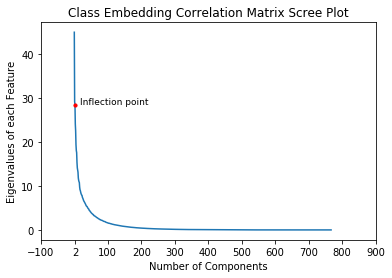

In [36]:
eigenvaluePCA(class_set['embeds'])
plt.title("Class Embedding Correlation Matrix Scree Plot")
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

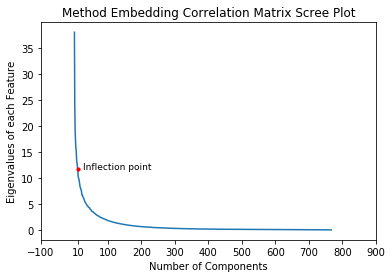

In [49]:
eigenvaluePCA(method_set['embeds'])
plt.title("Method Embedding Correlation Matrix Scree Plot")
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

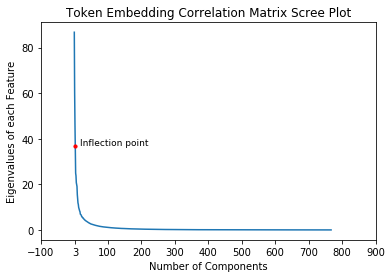

In [16]:
eigenvaluePCA(token_set['embeds'])
plt.title("Token Embedding Correlation Matrix Scree Plot")
plt.show

Principle Componenet Analysis: Use Sklearn PCA to determine feature importace/dimensionality. That is, we can find the number of components that explain P% of the variance

In [17]:
def thresholdPCA(embedding_cloud, threshold):
    '''
    input: point cloud and float between 0 and 1
    output: matplotlib histogram 

    PCA:
    1.) standardize the data
    2.) transform data with PCA
    3.) transform explained variance ratio list to a cumulative explained variance list
    4.) Use cumulative explained variance to determine how many components account for p% of total variance
    5.) plot threshold components on a histogram with their explained variance ratios
    '''
    if len(embedding_cloud) <= 1:
        print('Data not big enough!')
    else:

        scaler = StandardScaler()
        data_standardized = scaler.fit_transform(embedding_cloud)

        pca = PCA()
        pca.fit_transform(data_standardized)

        #returns number of components that account for p% of the total variance
        cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
        threshold_components = np.argmax(cumulative_variance >= threshold) + 1
        threshold_expained_variance = pca.explained_variance_ratio_[:threshold_components]
    

        # Plot the principle components with their respective explained variance ratios
        xaxis = np.arange(1,len(threshold_expained_variance)+1)
        fig = plt.bar(xaxis,threshold_expained_variance)
    
        plt.xlabel('Number of Components')
        plt.ylabel('Explained Variance Ratio')
        return fig

<function matplotlib.pyplot.show(*args, **kw)>

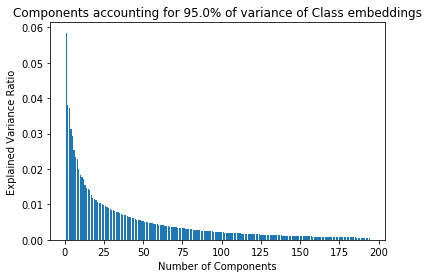

In [19]:
p = .95
thresholdPCA(class_set['embeds'],p)  
plt.title(f"Components accounting for {p*100}% of variance of Class embeddings")
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

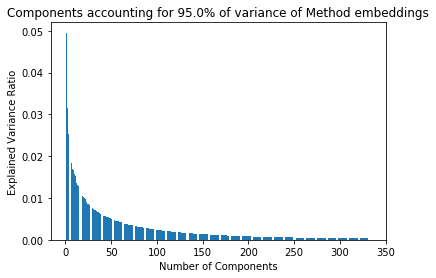

In [50]:
thresholdPCA(method_set['embeds'],p)  
plt.title(f"Components accounting for {p*100}% of variance of Method embeddings")
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

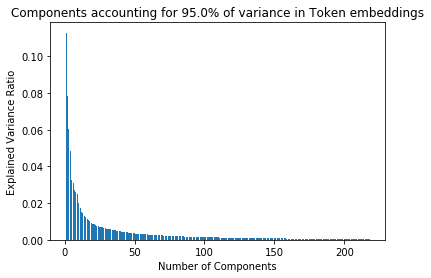

In [20]:
thresholdPCA(token_set['embeds'],p)  
plt.title(f"Components accounting for {p*100}% of variance in Token embeddings")
plt.show

### 3. Spacing/Clustering

Hierarchal Clustering

In [39]:
def hierarchyClustering(embedding_cloud, title):
    '''
    input: point cloud and figure title
    output: dendrogram cluster tree representation
    
    Hierarchal Clustering Analysis
    1.) make linkage that encodes tree associated with embedding clouse
    2.) use this linkage to make a dendrogram that visualizes tree, color coding significant clusters
    '''
    if len(embedding_cloud) <= 1:
        print('Not enough data!')
    else:
        linked = linkage(embedding_cloud, method='ward')
        dendrogram(linked)
        plt.title("Hierarchy Clustering Analysis for Ivy "+title)
        plt.show()  

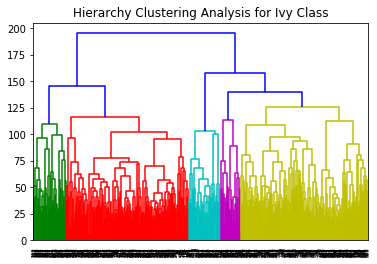

In [40]:
#Class
hierarchyClustering(class_set['embeds'],'Class')

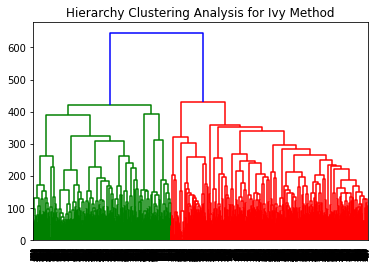

In [51]:
#Method
hierarchyClustering(method_set['embeds'],'Method')

In [ ]:
#Token
hierarchyClustering(token_set['embeds'],'Token')

Hierarchal clustering too computationally expensive for Token embeddings.

Pairwise Distance between Embeddings

In [10]:
def computePairwiseDistances(embedding_cloud,title):
  '''
  input: point cloud and figure title string
  output: matplotlib histogram

  Pairwise Distances (very inefficient O(n^2))
  1.) for each embedding, calculate the average distance to all other embeddings using l2-norm
  2.) add them to a list
  3.) plot the list on a histogram
  '''
  if len(embedding_cloud) <= 2:
    print('Not enough Data!')
    
  else:
    distances = []
    for i in range(len(embedding_cloud)):
      avg_distance = 0
      for j in range(len(embedding_cloud)):
        if i != j:
          distance = np.linalg.norm(np.array(embedding_cloud[i]) - np.array(embedding_cloud[j]))
          avg_distance += distance
      avg_distance /= len(embedding_cloud) - 1
      distances.append(avg_distance)
  
    avg = np.mean(distances)
    std = np.std(distances)

    plt.hist(distances, bins = round(len(embedding_cloud)/2), histtype='step', color=['blue'], fill=True, alpha=0.05)
    plt.axvline(avg, color='k', linestyle='dashed', linewidth=1)
    plt.axvline(avg+std, color='red', linestyle='dashed', linewidth=1)
    plt.axvline(avg-std, color='red', linestyle='dashed', linewidth=1)
    plt.xlabel('Pairwise Distance')
    plt.ylabel('Frequency')
    plt.title('Ivy ' + title + ' Pairwise Distance Histogram')
    plt.show()

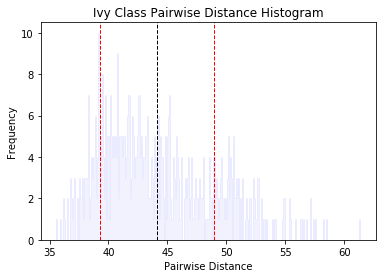

In [42]:
computePairwiseDistances(class_set['embeds'], 'Class')

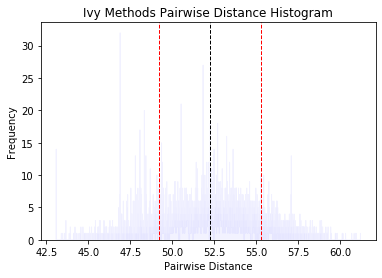

In [11]:
computePairwiseDistances(method_set['embeds'],'Methods')

Too computationally expensive to do for 400,000 tokens

### 4. Dynamism

Group embeddings based on token key word and analyze the distributions of the most commonly used tokens

In [40]:
def levelSorter(set,title):
    '''
    input: dictionary of certain granularity
    output: new dictionary containing the distributions for the top 5 most used token names
    
    1. sort token names by most to least common
    2. create a dictionary with top five names as keys
    3. traverse embeddings and if its corresponding name is one of the keys, append the embedding to that key
    '''
    mostFrequent, _ = Counter(set['names']).most_common(1)[0]
    mostFrequent_list = list()
    for i in range(len(set['embeds'])):
        if set['names'][i] == mostFrequent:
            mostFrequent_list.append(set['embeds'][i])
    if len(mostFrequent_list) <= 1:
        print(f"No duplicate {title}")
    else:
        computeL2Norms(mostFrequent_list)
        plt.title(f"all {len(mostFrequent_list)} L2 norms of most popular {title}: \"{mostFrequent}\"")
        plt.show

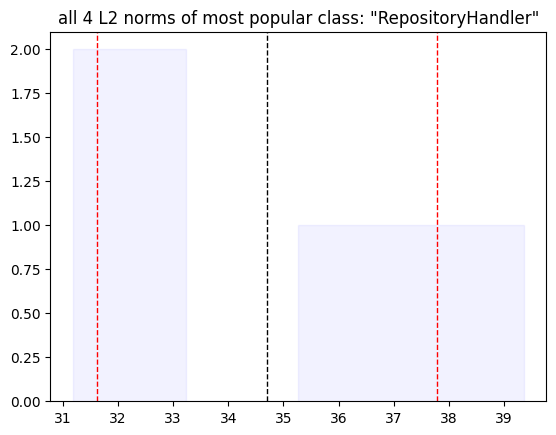

In [41]:
levelSorter(class_set, "class")

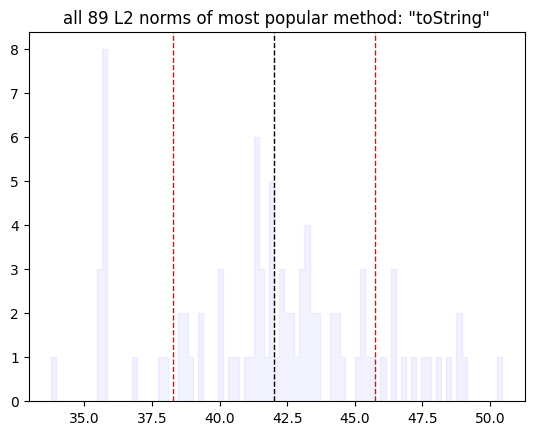

In [42]:
levelSorter(method_set, "method")

34857


<function matplotlib.pyplot.show(*args, **kw)>

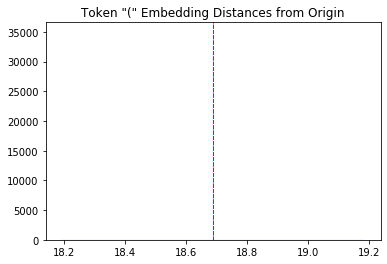

In [ ]:
levelSorter(token_set, "token")

### 5. Data Visualization/Outlier Detection

Principle Component Analysis: use PCA to tranform data to lower dimensionality then graph it on a scatter plot. Then use reverse transform to detect outliers from PCA

In [4]:
def visualPCA(set, title, threshold):
    '''
    input: class, method, or token dictionary created by cynthia's helper function path_to_data()
    output: matplot lib scatter representing a pca on the point cloud and a list of all the outliers detected outputed to system print

    Visual PCA
    1. standardize data
    2. use sklearn PCA to fit and transform data
    3. plot PCA on a scatterplot
    4. inverse transform the PCA-transformed data
    5. take the difference between the data and transformed data
    6. indices with biggest differences (transformed the most by the PCA) are considered outliers
    '''
    if len(set['embeds']) <= 1:
        print("Data not big enough")
    else:
        scaler = StandardScaler()
        data_standardized = scaler.fit_transform(set['embeds'])

        pca = PCA(n_components=2)
        principle_components = pca.fit_transform(data_standardized)

        plt.scatter(principle_components[:, 0], principle_components[:, 1], alpha=0.7)
        plt.title('PCA Visualization for Ivy'+title)
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.grid(True)
        plt.show()


        # Reconstruct the data
        pca_reconstructed = pca.inverse_transform(principle_components)
    
        # Calculate the reconstruction error for each data point
        errors = np.linalg.norm(data_standardized - pca_reconstructed, axis=1)
    
        # Detect outliers based on reconstruction error (thresholding)
        # Outliers are those with error significantly higher than the mean
        avg_error = np.mean(errors)
        std_error = np.std(errors)
    
        outlier_indices = np.where(errors > avg_error + threshold * std_error)[0]

        print('List of Outliers:')
        for outlier in outlier_indices:
            print(set['names'][outlier])

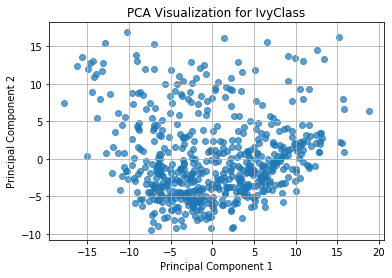

List of Outliers:
DissectedPath
HttpStatus
Attribute
ParseException
NotFilter
OrFilter
AndFilter
EventManager
FilteredIvyListener
ProfileNotFoundException
NoMatchMatcher
NoMatcher
ExactMatcher
AnyMatcher
LockData
Mapping
EmptyDirectoryScanner
EmptyIterator
Range
AntMessageLogger2


In [44]:
outliers = visualPCA(class_set,'Class')



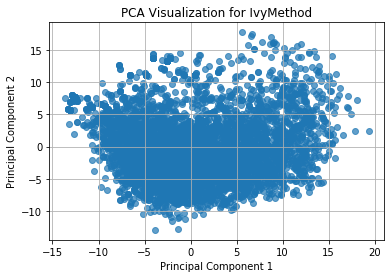

List of Outliers:
escape
getFileLength
readEntirely
getDefaultLogger
getTheAuthenticator
run
substitute
contains
readNext
toString
isOperator
encode
buildBundleURI
accept
accept
childHandled
accepts
equals
getChannelSftp
chomp
getParents


In [6]:
visualPCA(method_set,'Method',2)

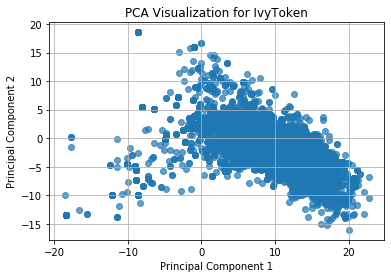

List of Outliers:
SLEEP_TIME
SLEEP_TIME
SAMPLING_SIZE
Couldn't instantiate 
SAMPLING_SIZE
SLEEP_TIME
SLEEP_TIME
SLEEP_TIME
SAXException
SAXException
ContextualSAXHandler
SAXException
SAXException
toCharArray
SHIFTS
Impossible to decrypt '
' not allowed
encrypt method can only be used with simple characters. '
'. Unhandled character.
SHIFTS
133
SHIFTS
SHIFTS
SHIFTS
uncapitalize
toCharArray
126
warns
MSG_DEBUG
WARN: 
DEPRECATED: 
MSG_INFO
AbstractMessageLogger
MSG_VERBOSE
WARN:  
MSG_INFO
warns
ERROR: 
MSG_WARN
MSG_VERBOSE
ERROR: 
warns
MSG_VERBOSE
Failed to set feature 
w3c
ALLOW_EXTERNAL_GENERAL_ENTITIES
SAXException
http://apache.org/xml/features/disallow-doctype-decl
SAXParseException
allowXmlDoctypeProcessing
http://apache.org/xml/features/nonvalidating/load-external-dtd
allowXmlDoctypeProcessing
EMPTY_INPUT_SOURCE
EMPTY_INPUT_SOURCE
toASCIIString
&lt;
http://xml.org/sax/features/external-general-entities
W3C_XML_SCHEMA
'&'
SAXParserFactory
file, jar:file
local-only
DISALLOW_DOCTYPE

SAXException
SAXException
P2CompositeParser
P2MetadataParser
SAXException
P2MetadataParser
p2CompositeParser
SAXException
p2CompositeParser
SAXException
P2Descriptor
readJarOrXml
P2Descriptor
readJarOrXml
readJarOrXml
P2Descriptor
readJarOrXml
feature.xml
UpdateSiteDigestParser
site.xml
SAXException
Cannot make an uri for the repo
P2MetadataParser
MSG_INFO
UpdateSiteDigestParser
P2Descriptor
URISyntaxException
MSG_VERBOSE
SAXException
IO issue while trying to read the update site (
AbstractOSGiResolver
Ill-formed url (
URISyntaxException
No update site was found at the location: 
Unknown log level: 
SAXException
MSG_INFO
Failed to parse the updatesite (
URISyntaxException
MSG_ERR
trying to download 
MSG_VERBOSE
AbstractOSGiResolver
MSG_WARN
Ill-formed updatesite (
MSG_INFO
MSG_INFO
FAILING_REPO_DESCRIPTOR
MSG_VERBOSE
MSG_DEBUG
BUNDLE_TYPE
'_'
BUNDLE_TYPE
'_'
%20
RelativeURLRepository
RelativeURLRepository
RelativeURLRepository
URISyntaxException
RelativeURLRepository
URISyntaxException

EXACT_OR_REGEXP
XSLTProcess
XmlReportOutputter
setXslfile
XSLTProcess
isGenerateRevConstraint
recursive.delivery.version
the ivy.status.default property
no status provided: either provide it as parameter or through 
or via 'ivy.organisation' property or a prior call to <resolve/>
getPubbranch
no organisation provided for ivy deliver task: 
 - delivered = 
It can either be set explicitly via the attribute 'organisation' 
impossible to deliver 
deliver ivy pattern is missing: either provide it as parameters 
ivy.deliver.ivy.pattern
or through ivy.deliver.ivy.pattern properties
recursive.delivery.status
DefaultPublishingDRResolver
no module name provided for ivy deliver task: 
ivy.delivery.list.file
dependency.published.version
ivy.organisation
java.io.tmpdir
: please enter a status: 
DefaultPublishingDRResolver
DefaultPublishingDRResolver
/delivery.properties
dependency.published.status
ivy.deliver.branch
ivy.deliver.revision
PublishingDependencyRevisionResolver
setReplaceForcedRevisions

In [29]:
visualPCA(token_set,'Token', 4)

T-SNE: Non Linear dimensionality reduction tool that is good at preserving pairwise distance between embeddings and identifying clusters

In [7]:

def visualTSNE(embedding_cloud,title):
    '''
    input: point cloud and figure title
    output: matplotlib scatterplot
    
    T-SNE
    1. declare a T-SNE with 2 components and random state at 42
    2. transform the data with the umap
    3. plot the transformed data on a scatterplot using matplotlib
    '''
    if len(embedding_cloud) <= 1:
        print('Data not big enough!')
    else:
        tsne = TSNE(n_components=2, random_state=42)
        reduced_data = tsne.fit_transform(embedding_cloud)

        plt.scatter(reduced_data[:, 0], reduced_data[:, 1], alpha=0.7)
        plt.title("t-SNE Visualization of Ivy "+ title)
        plt.show()

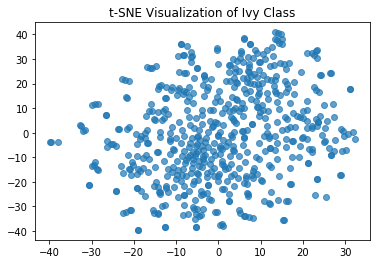

In [46]:
visualTSNE(class_set['embeds'],'Class')

/home/gabrown02/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/gabrown02/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


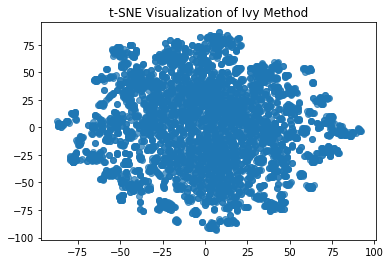

In [8]:
visualTSNE(method_set['embeds'],'Method')

In [ ]:
visualTSNE(token_set['embeds'],'Token')

Too computationally expensive for token embeddings

## Topological Feature Analysis:

### Helper functions for observing topological features with Rips Complex and DTM filtrations

Credit:
Gudhi for tree and persistance computation: https://github.com/GUDHI

Cynthia Xiong for addtional methods for visualizing persistance and computing betti numbers: 
https://github.com/CynthiaTheGriffin/topology_project/blob/main/AnalyticalEngineering2.ipynb

Vincent Rouvreau for DTM filtration functions: https://github.com/GUDHI/TDA-tutorial/blob/master/DTM_filtrations.py

In [6]:
'''
From Cynthia
'''

def plot_persistence(persist):
    fig, ax = plt.subplots(ncols=2)
    fig.set_figwidth(10)
    fig.set_figheight(4)
    gudhi.plot_persistence_diagram(persist, axes=ax[0])
    gudhi.plot_persistence_barcode(persist, axes=ax[1])
    return fig, ax

def compute_betti_numbers(simp_tree, persist=None):
    if persist is None:
        persist = simp_tree.persistence()
        
    if persist == [(0, (0.0, np.inf))]*len(persist):
        # This occurs when max_edge_length is too low, and simplicial complex is all verticies and no edges
        # Do not call betti_numbers(), lest the kernel crashes
        return [len(persist)] # \beta_0 = number of embeddings
    else:        
        return simp_tree.betti_numbers()
    
def GetBettiCurvesFromPointCloud(X, J, dim=3):
    '''
    Computes the Betti curves of the Rips complex on the point cloud X, 
    on the interval J, up to dimension dim.

    Input:
        X (np.array): size Nx2, the point cloud.
        J (np.array): interval. Shape 1xM. 
        dim (int, optional): maximal dimension to compute the Betti curves. 
    
    Output:
        BettiCurves (np.array): the Betti curves. Shape (dim+1w)xM. The ith 
                                Betti curve is given by BettiCurve[i,:].  
                                
    Example:
        X = np.asarray([[0,1],[1,0],[-1,1]])
        J = np.linspace(0,1,100)
        GetBettiCurvesFromPointCloud(X, J, dim = 2)
    '''
    I = 2*J
    tmax = max(I)
    rips = gudhi.RipsComplex(points=X, max_edge_length = tmax)
    st = rips.create_simplex_tree(max_dimension=dim)
    st.persistence(persistence_dim_max=True, homology_coeff_field = 2)
    Diagrams = [st.persistence_intervals_in_dimension(i) for i in range(dim+1)]
    BettiCurves = []
    step_x = I[1]-I[0]
    for diagram in Diagrams:
        bc =  np.zeros(len(I))
        if diagram.size != 0:
            diagram_int = np.clip(np.ceil((diagram[:,:2] - I[0]) / step_x), 0, len(I)).astype(int)
            for interval in diagram_int:
                bc[interval[0]:interval[1]] += 1
        BettiCurves.append(np.reshape(bc,[1,-1]))
    return np.reshape(BettiCurves, (dim+1, len(I)))

Helper functions for DTM Filtrations

In [7]:
'''
From Vincent Rouvreau
'''

def DTM(X,query_pts,m):
    '''
    Compute the values of the DTM (with exponent p=2) of the empirical measure of a point cloud X
    Require sklearn.neighbors.KDTree to search nearest neighbors
    
    Input:
    X: a nxd numpy array representing n points in R^d
    query_pts:  a kxd numpy array of query points
    m: parameter of the DTM in [0,1)
    
    Output: 
    DTM_result: a kx1 numpy array contaning the DTM of the 
    query points
    
    Example:
    X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
    Q = np.array([[0,0],[5,5]])
    DTM_values = DTM(X, Q, 0.3)
    '''
    N_tot = X.shape[0]     
    k = math.floor(m*N_tot)+1   # number of neighbors

    kdt = KDTree(X, leaf_size=30, metric='euclidean')
    NN_Dist, NN = kdt.query(query_pts, k, return_distance=True)  

    DTM_result = np.sqrt(np.sum(NN_Dist*NN_Dist,axis=1) / k)
    
    return(DTM_result)


def WeightedRipsFiltrationValue(p, fx, fy, d, n = 10):
    '''
    Computes the filtration value of the edge [x,y] in the weighted Rips filtration.
    If p is not 1, 2 or 'np.inf, an implicit equation is solved.
    The equation to solve is G(I) = d, where G(I) = (I**p-fx**p)**(1/p)+(I**p-fy**p)**(1/p).
    We use a dichotomic method.
    
    Input:
        p (float): parameter of the weighted Rips filtration, in [1, +inf) or np.inf
        fx (float): filtration value of the point x
        fy (float): filtration value of the point y
        d (float): distance between the points x and y
        n (int, optional): number of iterations of the dichotomic method
        
    Output: 
        val (float): filtration value of the edge [x,y], i.e. solution of G(I) = d.
    
    Example:
        WeightedRipsFiltrationValue(2.4, 2, 3, 5, 10)
    '''
    if p==np.inf:
        value = max([fx,fy,d/2])
    else:
        fmax = max([fx,fy])
        if d < (abs(fx**p-fy**p))**(1/p):
            value = fmax
        elif p==1:
            value = (fx+fy+d)/2
        elif p==2:
            value = np.sqrt( ( (fx+fy)**2 +d**2 )*( (fx-fy)**2 +d**2 ) )/(2*d)            
        else:
            Imin = fmax; Imax = (d**p+fmax**p)**(1/p)
            for i in range(n):
                I = (Imin+Imax)/2
                g = (I**p-fx**p)**(1/p)+(I**p-fy**p)**(1/p)
                if g<d:
                    Imin=I
                else:
                    Imax=I
            value = I
    return value


def WeightedRipsFiltration(X, F, p, dimension_max =2, filtration_max = np.inf):
    '''
    Compute the weighted Rips filtration of a point cloud, weighted with the 
    values F, and with parameter p
    
    Input:
    X: a nxd numpy array representing n points in R^d
    F: an array of length n,  representing the values of a function on X
    p: a parameter in [0, +inf) or np.inf
    filtration_max: maximal filtration value of simplices when building the complex
    dimension_max: maximal dimension to expand the complex
    
    Output:
    st: a gudhi.SimplexTree 
    '''
    N_tot = X.shape[0]     
    distances = euclidean_distances(X)          # compute the pairwise distances
    st = gudhi.SimplexTree()                    # create an empty simplex tree

    for i in range(N_tot):                      # add vertices to the simplex tree
        value = F[i]
        if value<filtration_max:
            st.insert([i], filtration = F[i])            
    for i in range(N_tot):                      # add edges to the simplex tree
        for j in range(i):
            value = WeightedRipsFiltrationValue(p, F[i], F[j], distances[i][j])
            if value<filtration_max:
                st.insert([i,j], filtration  = value)
    
    st.expansion(dimension_max)                 # expand the simplex tree
 
    result_str = 'Weighted Rips Complex is of dimension ' + repr(st.dimension()) + ' - ' + \
        repr(st.num_simplices()) + ' simplices - ' + \
        repr(st.num_vertices()) + ' vertices.' +\
        ' Filtration maximal value is ' + str(filtration_max) + '.'
    print(result_str)

    return st

def DTMFiltration(X, m, p, dimension_max =2, filtration_max = np.inf):
    '''
    Compute the DTM-filtration of a point cloud, with parameters m and p
    
    Input:
    X: a nxd numpy array representing n points in R^d
    m: parameter of the DTM, in [0,1) 
    p: parameter of the filtration, in [0, +inf) or np.inf
    filtration_max: maximal filtration value of simplices when building the complex
    dimension_max: maximal dimension to expand the complex
    
    Output:
    st: a gudhi.SimplexTree 
    '''
    
    DTM_values = DTM(X,X,m)
    st = WeightedRipsFiltration(X, DTM_values, p, dimension_max, filtration_max)

    return st

### Class Analysis:

In [45]:
# 2 minutes
tree = gudhi.RipsComplex(points= class_set['embeds'], max_edge_length=40).create_simplex_tree(max_dimension=3)
persist = tree.persistence()

Betti numbers: [26, 3, 0]


c:\Users\gbrow\Code\python\.venv\Lib\site-packages\gudhi\persistence_graphical_tools.py:107: UserWarning: usetex mode requires TeX.
  warnings.warn("usetex mode requires TeX.")


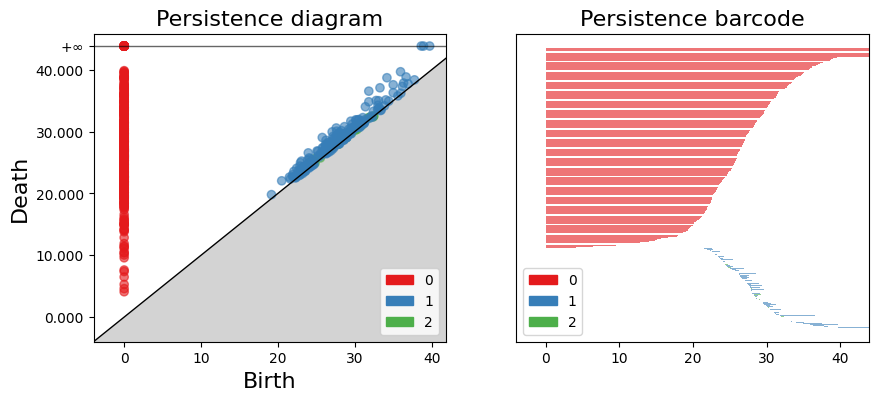

In [46]:
print("Betti numbers:", compute_betti_numbers(tree, persist))
plot_persistence(persist)
plt.show()

Increase Max-edge length to 50 and reduce max-dimensions to 2

In [47]:
tree1 = gudhi.RipsComplex(points=class_set['embeds'], max_edge_length=50).create_simplex_tree(max_dimension=2)
persist1 = tree1.persistence()

Betti numbers: [1, 0]


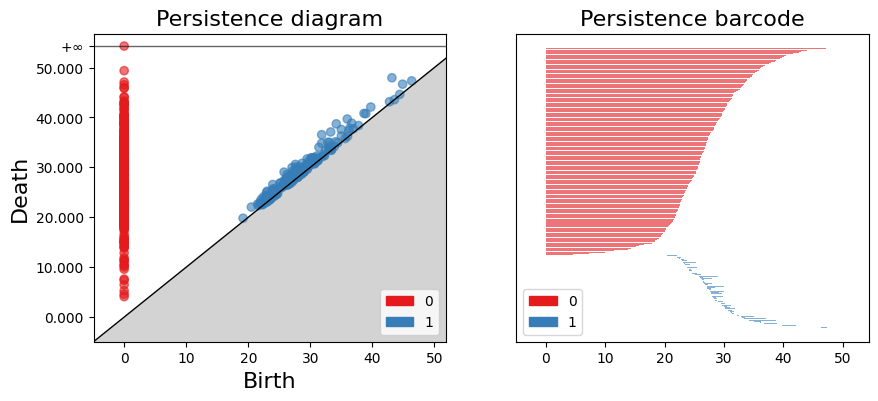

In [48]:
print("Betti numbers:", compute_betti_numbers(tree1, persist1))
plot_persistence(persist1)
plt.show()

DTM filtration

In [ ]:
'''
Same parameters used by Michael Wojdak in https://github.com/Michael-Wojdak/tda_project/blob/main/dtm.py 
m = 0.1
p = 1
max_dim = 2
'''
DTM_filt_class = DTMFiltration(class_set['embeds'], m = .1, p = 1, dimension_max = 2)
DTM_persist_class = DTM_filt_class.persistence()


Weighted Rips Complex is of dimension 2 - 32351239 simplices - 579 vertices. Filtration maximal value is inf.


Betti numbers: [1, 0]


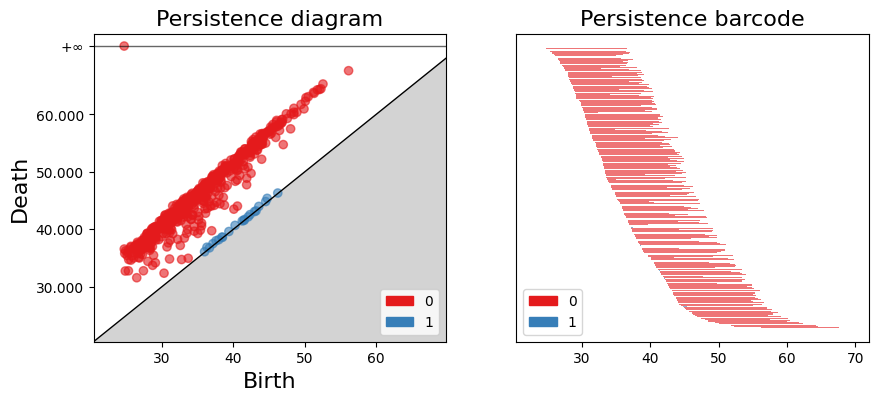

In [54]:
print("Betti numbers:", compute_betti_numbers(DTM_filt_class, DTM_persist_class))
plot_persistence(DTM_persist_class)
plt.show()

### Method Analysis

Method Analysis could not be run on this machine. Used results from Cyntha and Michael whose results are locations here:
https://github.com/Michael-Wojdak/tda_project/tree/main/figures
https://github.com/CynthiaTheGriffin/topology_project/blob/main/AnalyticalEngineering2.ipynb

In [ ]:
tree = gudhi.RipsComplex(points=method_set['embeds'], max_edge_length=40).create_simplex_tree(max_dimension=3)
persist = tree.persistence()

In [ ]:
print("Betti numbers:", compute_betti_numbers(tree, persist))
plot_persistence(persist)
plt.show()

NameError: name 'tree' is not defined

Increase Max-edge length to 50 and reduce max-dimensions to 2

In [ ]:
# 16 minutes
tree2 = gudhi.RipsComplex(points=method_set['embeds'], max_edge_length=50).create_simplex_tree(max_dimension=2)
persist2 = tree2.persistence()

In [ ]:
print("Betti numbers:", compute_betti_numbers(tree2, persist2))
plot_persistence(persist2)
plt.show()

DTM Filtration:

In [ ]:
'''
Same parameters used by Michael Wojdak in https://github.com/Michael-Wojdak/tda_project/blob/main/dtm.py 
m = 0.1
p = 1
max_dim = 2
'''
DTM_filt_methods = DTMFiltration(method_set['embeds'], m = .1, p = 1, dimension_max = 2)
DTM_persist_methods = DTM_filt_methods.persistance()

In [ ]:
print("Betti numbers:", compute_betti_numbers(DTM_filt_methods, DTM_persist_methods))
plot_persistence(DTM_persist_methods)
plt.show()

### Token topological feature exploration is too computationally expensive. Will talk about this in future works.